In [133]:
# MINIMIZING AVG PAIRWISE DIST

In [1]:
import sys
from gurobipy import *
import math
from matplotlib import pyplot as plt

In [2]:
#get data from .jld files
#https://docs.h5py.org/en/stable/high/group.html
#https://docs.h5py.org/en/stable/high/attr.html

import h5py
x1_data = h5py.File("X1.jld", "r")
x2_data = h5py.File("X2.jld", "r")
x3_data = h5py.File("X3.jld", "r")

# simple logic for switching between different instances of the problem (different client locations)
# sets parameters of the problem and loads coordinate data into X (2D array)
    # X[0]: all 25 "x" coordinates
    # X[1]: "y" coordinates

instance = 2
# 1 or 2 (3 not feasible)

if instance == 1:
    n_min = 2
    n_max = 8
    d_max = 10
    X = [x1_data["X"][0], x1_data["X"][1]]
elif instance == 2:
    n_min = 4
    n_max = 6
    d_max = 9
    X = [x2_data["X"][0], x2_data["X"][1]]
else:
    print("Error: instance needs to be 1 or 2")

n = len(X[0]) 
n #should be 25

25

In [4]:
# create model
myModel = Model( "ClientDepot_MinDist" )

# Create variables and put them into arrays for reference in the model:

Y = []
for i in range(n):
    Y.append([])
    for j in range(n):
        Y[i].append(0)
        Y[i][j] = myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY )
# Y is an assignment matrix:
# Y[i][j] = 1: client i is assigned to depot j, otherwise 0
# each entry of Y is its own decision variable
# NOTE: I always use i (or ii) to index clients and j to index depots

# depots = [myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY ) for j in range(n)]
# #depots is a vector that indicates whether a depot has clients assigned to it
# #depots[j] = 0: no clients assigned to depot j.
# #          = 1: one or more clients assigned to depot j.

Z = []
for i in range(n):
    Z.append([])
    for ii in range(n):
        Z[i].append(None)
        Z[i][ii] = myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY )
# Z is a matrix that indicates whether clients i and ii are in the same depot
#expensive to build in every iteration. Can we do without this?

D = []
for i in range(n):
    D.append([])
    for ii in range(n):
        D[i].append( math.sqrt((X[0][i] - X[0][ii])**2 + (X[1][i] - X[1][ii])**2) )
# Distance matrix: D[i][ii] is the distance between clients i and ii


myModel.update()

In [5]:
# objective: MINIMIZE PARIWISE DISTANCE

# find an expression for total pairwise distance, 
# then select only the pairs that are in the same cluster.

#subroutine: find pairwise distance for clients in a cluster
def getPairwiseDist(indices):
    n = len(indices)
    if n < 2:
        return 0
    dist = 0
    numPairs = 0
    while len(indices) > 1:
        for i in indices[1:]:
            dist += D[0][i]
            numPairs += 1
        indices = indices[1:] 
    return (dist, numPairs)

d = getPairwiseDist(range(25))
print(d)


objExpr = LinExpr()
for i in range(n):
    for ii in range(n):
        objExpr += D[i][ii] * Z[i][ii] / 2
    
myModel.setObjective( objExpr , GRB.MINIMIZE )

(3219.776560365756, 300)


In [6]:
# create expressions for constraints and add to the model

#ZEROTH CONSTRAINT: definition of Z
#matrix that indicates whether two clients are in the same depot

# clients i, ii in j ==> Z[i][ii] = 1

for j in range(n):
    
    for i in range(n):
        for ii in range(n):
            
            myModel.addConstr( lhs = Z[i][ii] , sense = GRB.GREATER_EQUAL , rhs = Y[i][j] + Y[ii][j] - 1 ) 
            #Y[i][j] + Y[ii][j] - 1
            # if Y[i][j] and Y[ii][j] are both 1, then Z[i][ii] >= 1, so it will be 1. 
            # Otherwise this constraint is satisfied by any value of Z[i][ii]
            
            

# #IMPROVED FIRST CONSTRAINT
#     # we don't need to worry about an upper bound on Y since it is being minimized in the objective function
#     # so we only need to ensure that Y[i][j] = 1 ==> depots[j] = 1, not the reverse
#     # the former constraint is sufficient, but mathematically dominated by the following formulation:
#         # Y[i][j] <= depots[j] for all i, j
# for i in range(n):
#     for j in range(n):
#         myModel.addConstr( lhs = Y[i][j] , sense = GRB.LESS_EQUAL , rhs = depots[j] )

#SECOND CONSTRAINT: client-depot uniqueness
#ensures that the sum of each row of Y is exactly 1 (each client assigned to one unique depot)
secondConst = [LinExpr() for i in range(n)]
for i in range(n):
    for j in range(n):
        secondConst[i] += Y[i][j]
    
    myModel.addConstr( lhs = secondConst[i] , sense = GRB.EQUAL , rhs = 1 )

    
#IMPROVED THIRD CONSTRAINT: min and max clients constraint
#the sum of the j-th column of Y must be between n_min and n_max 
#new formulation is done without the depots variables
thirdConst = [LinExpr() for j in range(n)]
for j in range(n):
    for i in range(n):
        thirdConst[j] += Y[i][j]
        
    myModel.addConstr( lhs = thirdConst[j] , sense = GRB.LESS_EQUAL , rhs = n_max )
    myModel.addConstr( lhs = thirdConst[j]**2 , sense = GRB.GREATER_EQUAL , rhs = n_min*thirdConst[j] )
    
#FOURTH CONSTRAINT: max distance constraint
#ensures that any two clients belonging to the same depot are no further than d_max from each other

#Look at each pair of clients i and ii in depot j
for i in range(n):
    for ii in range(n): 

        # act is very large if client i or ii is not in the depot, else 0
        myModel.addConstr( lhs = D[i][ii]*Z[i][ii], sense = GRB.LESS_EQUAL , rhs = d_max )

        #if Y[i][j] or Y[ii][j] = 0, the constraint will be satisfied automatically (rhs will be very large)
        #if they are both 1, then the constraint is "act"ivated, 
        #so the distance between that pair must be less than d_max

In [7]:
# integrate objective and constraints into the model
myModel.update()
# write the model in a file to make sure it is constructed correctly
myModel.write( filename = "testOutput_C.lp" )
# optimize the model
myModel.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16300 rows, 1250 columns and 48100 nonzeros
Model fingerprint: 0x551bba07
Model has 25 quadratic constraints
Variable types: 0 continuous, 1250 integer (1250 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [4e+00, 4e+00]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 10298 rows and 445 columns
Presolve time: 0.05s
Presolved: 21027 rows, 8305 columns, 59497 nonzeros
Variable types: 0 continuous, 8305 integer (8305 binary)

Root relaxation: objective 0.000000e+00, 3408 iterations, 0.21 seconds (0.47 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    

  4957  2655 infeasible   37       120.50878   18.48400  84.7%  1055  473s
  5045  2723   21.90953   39 2197  120.50878   18.48400  84.7%  1066  484s
  5175  2773   27.40684   42 2033  120.50878   18.48400  84.7%  1078  497s
  5282  2884   24.38251   45 1994  120.50878   18.48400  84.7%  1098  510s
  5487  2903   24.61620   48 1932  120.50878   18.48400  84.7%  1096  524s
  5619  2950   25.04372   51 1894  120.50878   18.48400  84.7%  1115  538s
H 5668  2845                     120.5087774   18.48400  84.7%  1126  538s
  5722  2936   25.29628   55 1785  120.50878   18.48400  84.7%  1135  552s
  5915  3005 infeasible   58       120.50878   18.48400  84.7%  1145  566s
  6098  3054   29.76359   59 1780  120.50878   18.48400  84.7%  1152  580s
  6241  3126   30.09910   62 1707  120.50878   18.48400  84.7%  1169  595s
  6406  3252   30.34991   66 1654  120.50878   18.48400  84.7%  1180  610s
  6633  3339   30.48196   68 1653  120.50878   18.48400  84.7%  1180  627s
H 6688  3237             

 30505 19200   58.82808   64 1305  120.50877   27.45737  77.2%  1346 3092s
 30574 19217   70.48977   72 1060  120.50877   27.45737  77.2%  1347 3101s
 30618 19250 infeasible   79       120.50877   27.45737  77.2%  1349 3108s
 30677 19271   28.53510   52 1955  120.50877   27.45737  77.2%  1350 3116s
 30730 19316   36.60692   55 1815  120.50877   27.45737  77.2%  1352 3124s
 30801 19378   47.60382   59 1629  120.50877   27.45737  77.2%  1353 3133s
 30914 19407   49.16398   65 1734  120.50877   27.45737  77.2%  1353 3141s
 31007 19424   56.60849   72 1404  120.50877   27.45737  77.2%  1353 3151s
 31081 19479   75.24940   75 1130  120.50877   27.45737  77.2%  1355 3160s
 31181 19496   91.62750   98  890  120.50877   27.45737  77.2%  1356 3171s
 31277 19535   31.28271   55 1750  120.50877   27.45737  77.2%  1357 3181s
 31356 19596   45.68087   61 1739  120.50877   27.45737  77.2%  1359 3191s
 31457 19615   49.50357   66 1707  120.50877   27.45737  77.2%  1360 3204s
 31538 19640   55.72538  

 84166 39797   83.63993   91 1056  120.50875   34.24993  71.6%  1749 16644s
 85032 40270  100.97643   94  430  120.50875   34.32227  71.5%  1748 16773s
 85695 40708   70.46336   81 1477  120.50875   34.36989  71.5%  1753 16904s
 86315 41344   88.14515   81  869  120.50875   34.38354  71.5%  1757 17034s
 87177 41907   68.64080   79 1500  120.50875   34.43030  71.4%  1758 17163s
 88069 42470   60.45123   69  702  120.50875   34.49160  71.4%  1755 17282s
 88829 43202   58.86028   56 1535  120.50875   34.52003  71.4%  1757 17417s
 89764 43789  101.58910   72  471  120.50875   34.55425  71.3%  1756 17536s
 90606 44322   65.89988   71 1499  120.50875   34.60654  71.3%  1756 17651s
 91287 44886   82.79446  101 1190  120.50875   34.64656  71.2%  1758 17778s
 92049 45350   35.26990   69 1304  120.50875   34.68793  71.2%  1759 17895s
 92733 45865   37.44847   72 1517  120.50875   34.73794  71.2%  1762 17995s
 93492 46214   38.33704   65 1755  120.50875   34.79715  71.1%  1764 18094s
 93939 46710

In [8]:
# print optimal objective and optimal solution
print( "Optimal Objective: ", myModel.ObjVal )

#print( "\nOptimal Solution:" )
Y_vals = []
for i in range(n):
    Y_vals.append([])
    for j in range(n):
        Y_vals[i].append(int(Y[i][j].x))

for i in range(n):
    print(Y_vals[i])

Optimal Objective:  120.50878551646612
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
# Grab the indices of the clusters:
depots_vals = []
for j in range(n):
    depots_vals.append(0)
    for i in range(n):
        if Y[i][j].x == 1:
            depots_vals[j] = 1
        
        
        
#depots_vals = [int(val.x) for val in depots]
print(depots_vals)

def clusters(assign_matrix):
    clusts = []
    
    for j in range(len(depots_vals)):
        
        if depots_vals[j] == 1: #check if the col of Y is a depot
            
            clusts.append([])
            for i in range(n):
                
                if assign_matrix[i][j] == 1:
                     clusts[-1].append(i)
    
    return clusts

clusters(Y_vals)

[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]


[[2, 14, 22, 24],
 [1, 3, 5, 7, 13],
 [10, 11, 17, 21],
 [0, 9, 18, 23],
 [8, 16, 19, 20],
 [4, 6, 12, 15]]

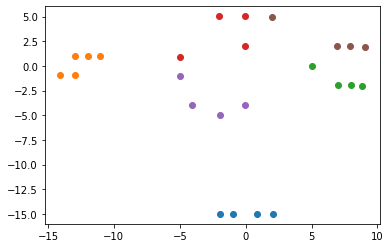

In [10]:
# Create scatterplot


c = clusters(Y_vals)

X_colors_0 = []
for i in range(len(c)):
    X_colors_0.append([])
    
    for index in c[i]:
        X_colors_0[i].append(X[0][index])

        
X_colors_1 = []
for i in range(len(c)):
    X_colors_1.append([])
    
    for index in c[i]:
        X_colors_1[i].append(X[1][index])

for i in range(len(X_colors_1)):
    
    plt.scatter(X_colors_0[i], X_colors_1[i])   